# Package Imports

In [1]:
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import networkx as nx
from tqdm.auto import tqdm
import random
import math
import pickle
import torch
from torch import Tensor
import pandas as pd
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import to_undirected, is_undirected
import numpy as np
from networkx import to_dict_of_dicts
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, HGTLoader,NeighborSampler
from torch_geometric.utils import mask_select, index_to_mask
import os

c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.version_info


sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)

In [3]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.randn(1).cuda())

2.2.2+cu118
11.8
tensor([1.4245], device='cuda:0')


# Data Load

In [4]:
import pickle

# First, extract the contents of dataset.rar to a folder

# Then, load the data from the dataset.pickle file
with open('data/MRecury_data/dataset_typed.pickle', 'rb') as f:
    dataset = pickle.load(f)

# Now you can access the different parts of the dataset:
full_graph = dataset['full']
train_graph = dataset['train']
test_graph = dataset['test']
users_mapping = dataset['users']
#artist_tracks_mapping = dataset['artist-tracks']
# Load New Mapping: 
artist_tracks_mapping = pd.read_csv('data/new_artist_tracks_mapping_df.csv')


# Accessing nodes and edges of the graphs:
full_nodes = full_graph.nodes()
full_edges = full_graph.edges()

train_nodes = train_graph.nodes()
train_edges = train_graph.edges()

test_nodes = test_graph.nodes()
test_edges = test_graph.edges()



In [5]:
def load_social(file_users, file_edges, users_ids):
    df_users = pd.read_csv(file_users, sep='\t', names=['id', 'user'])
    df_edges = pd.read_csv(file_edges, sep=' ', names=['origin', 'destination'])
    old_new = {}
    for _, r in tqdm(df_users.iterrows(), total=len(df_users)):
        if r['user'] in users_ids:
            old_new[r['id']] = users_ids[r['user']]
    social_graph = nx.DiGraph()
    social_graph.add_nodes_from(old_new.values())
    for _, r in tqdm(df_edges.iterrows(), total=len(df_edges)):
        if r['origin'] in old_new and r['destination'] in old_new:
            social_graph.add_edge(old_new[r['origin']], old_new[r['destination']])
    return social_graph

social_graph = load_social('data/MRecury_data/lastfm.nodes', 'data/MRecury_data/lastfm.edges', users_mapping)

100%|██████████| 1685524/1685524 [00:17<00:00, 98425.49it/s] 


In [6]:
# Load your saved HeteroData object
pyg = torch.load('data/pyg_data/train_hetero_data_3_nodes_rich.pt')
pyg

HeteroData(
  users={ node_id=[3307] },
  songs={
    node_id=[252013],
    x_audio=[252013, 11],
    x_tag=[252013, 3],
  },
  artists={
    node_id=[28120],
    x_tag=[28120, 3],
  },
  (users, listens_to, songs)={
    edge_index=[2, 2564907],
    edge_attr=[2564907],
  },
  (users, is_friends_with, users)={ edge_index=[2, 142919] },
  (artists, makes, songs)={ edge_index=[2, 252013] },
  (songs, rev_listens_to, users)={
    edge_index=[2, 2564907],
    edge_attr=[2564907],
  },
  (users, rev_is_friends_with, users)={ edge_index=[2, 142919] },
  (songs, rev_makes, artists)={ edge_index=[2, 252013] }
)

In [7]:
data = []
g_train = dataset['train']
for u in tqdm(dataset['users'].values()):
    for s in g_train[u]:
        data.append([u, s, g_train.edges()[(u, s)]['scrobbles']])
 
df = pd.DataFrame(data=data, columns=['user', 'track', 'scrobbles'])

100%|██████████| 3307/3307 [00:03<00:00, 894.48it/s] 


# Embeddings

## Edge Comparison

### Original NX User Track Edges
Comparing if the edges of my PyG Training Graph and original NX Graph are the same

In [8]:
edge_list_pyg = list(zip(pyg["users", "listens_to","songs"]["edge_index"][0].tolist(), pyg["users", "listens_to","songs"]["edge_index"][1].tolist()))

### New PyG User Track Edges

In [9]:
users = pyg["users"]["node_id"]

In [10]:
def extract_songs_per_user(users, edge_index):
    tracks_per_user = []
    users_per_track = []
    for u_node in range(len(users)):
            neighbor_indices = edge_index[1][edge_index[0] == u_node]  # Get neighbor indices #second bracket is a mask that selects only edges for which boolean holds True!
            
            for t_track in neighbor_indices:
                tracks_per_user.append(t_track)
                users_per_track.append(u_node)
    return users_per_track, tracks_per_user

In [11]:
users_per_track, tracks_per_user = extract_songs_per_user(users, pyg["users", "listens_to","songs"]["edge_index"])

In [12]:
x1 = np.asarray(users_per_track, dtype=np.int32)[:, np.newaxis]
x2 = np.asarray(tracks_per_user, dtype=np.int32)[:, np.newaxis]

In [13]:
x1,x2

(array([[   0],
        [   0],
        [   0],
        ...,
        [3306],
        [3306],
        [3306]]),
 array([[  2928],
        [  3039],
        [  3153],
        ...,
        [   508],
        [  8884],
        [170124]]))

## Embedding Model

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Add, Lambda, Concatenate, Activation
from tensorflow.keras.models import Model
import functools
import tensorflow.keras.backend as K
from scipy.sparse import dok_matrix
import random
import os


seed_value = 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

In [15]:
def base_model(users, tracks, vector_dim=64):
    """
    A Keras implementation of the GloVe architecture
    :param vocab_size: The number of distinct words
    :param vector_dim: The vector dimension of each word
    :return:
    """
    input_target = Input((1,), name='user_id')
    input_context = Input((1,), name='track_id')

    central_embedding = Embedding(users, vector_dim, name='user_emb')

    context_embedding = Embedding(tracks, vector_dim, name='track_emb')
    """
    central_embedding = Embedding(users, vector_dim, input_length=1, name='user_emb')

    context_embedding = Embedding(tracks, vector_dim, input_length=1, name='track_emb')
    """
    vector_target = central_embedding(input_target)
    vector_context = context_embedding(input_context)

    dot_product = Dot(axes=-1)([vector_target, vector_context])
    prediction = Reshape((1, ))(dot_product)
    prediction = Activation('sigmoid')(prediction)

    model = Model(inputs=[input_target, input_context], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    model.summary()

    return model

In [16]:
model = base_model(len(pyg['users']["node_id"]), len(pyg['songs']["node_id"]), 10)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ track_id            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_emb            │ (None, 1, 10)     │     33,070 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ track_emb           │ (None, 1, 10)     │  2,520,130 │ track_id[0][0]    │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1, 1)      │          0 │ user_emb[0][0],   │
│                     │                   │            │ track_emb[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1)         │          0 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ reshape[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,553,200 (9.74 MB)

 Trainable params: 2,553,200 (9.74 MB)

 Non-trainable params: 0 (0.00 B)

### Negative Sampling

In [17]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import math


class NegSampling(Sequence):
    
    def __init__(self, users, tracks, n_users, n_tracks, batch_size):
        self.users = users
        self.tracks = tracks
        self.n_users = n_users
        self.n_tracks = n_tracks
        self.batch_size = batch_size
        #print(users, tracks, n_users, n_tracks, batch_size)
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(self.tracks.shape[0] / self.batch_size)
    
    def __getitem__(self, idx):
        x1 = self.users[idx * self.batch_size:(idx+1) * self.batch_size:, ...]
        x2 = self.tracks[idx * self.batch_size:(idx+1) * self.batch_size:, ...]
        y = np.ones((x1.shape[0], 1))
        x1_n = np.random.randint(0, self.n_users, size=x1.shape)
        x2_n = np.random.randint(0, self.n_tracks, size=x2.shape)
        y_n = np.zeros_like(y)
        return (np.concatenate((x1, x1_n), axis=0),
                np.concatenate((x2, x2_n), axis=0)), np.concatenate((y, y_n), axis=0)
    
    def on_epoch_end(self):
        self.users, self.tracks = shuffle(self.users, self.tracks)

In [18]:
ds = NegSampling(x1, x2, len(users),len(pyg["songs"]["node_id"]), 500)

In [19]:
ds[0]

((array([[1960],
         [2614],
         [ 146],
         [2285],
         [ 321],
         [ 122],
         [ 247],
         [ 170],
         [ 447],
         [ 955],
         [ 127],
         [2579],
         [1644],
         [  37],
         [1680],
         [1674],
         [1291],
         [ 192],
         [1327],
         [   3],
         [  79],
         [ 450],
         [ 718],
         [1113],
         [1082],
         [ 100],
         [2778],
         [  27],
         [   6],
         [   5],
         [1914],
         [1388],
         [ 413],
         [1722],
         [1130],
         [   4],
         [1678],
         [1041],
         [1127],
         [1588],
         [1449],
         [1176],
         [   0],
         [2339],
         [ 116],
         [1068],
         [  11],
         [2776],
         [2521],
         [1632],
         [ 795],
         [1135],
         [3112],
         [1658],
         [3215],
         [ 827],
         [2511],
         [3228],
         [1456

## Embedding Training:


In [20]:
if not os.path.exists('data/embeddings/cosines/embeddings_model.weights.h5'):
    model.fit(NegSampling(x1, x2,
                         len(dataset['users']), 
                         len(pyg["songs"]["node_id"]),
                         500), epochs=15) 
    model.save_weights('data/embeddings/cosines/embeddings_model.weights.h5')
else:
    model.load_weights('data/embeddings/cosines/embeddings_model.weights.h5') # 
    print("Loaded model from disk")

Loaded model from disk


c:\Users\Timo\.pyenv\pyenv-win\versions\3.12.2\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [21]:
print(model.layers[2].name)
users_embs = K.get_value(model.layers[2].embeddings)
print(model.layers[3].name)
tracks_embs = K.get_value(model.layers[3].embeddings)

user_emb
track_emb


In [22]:
users_embs.shape

(3307, 10)

In [23]:
tracks_embs.shape

(252013, 10)

In [24]:
tracks_embs

array([[-0.1780192 , -0.7199413 ,  0.6536726 , ..., -0.33141312,
        -0.8238672 , -0.13562447],
       [-0.0889021 , -0.20431122,  0.5112629 , ..., -0.55016273,
        -0.6536234 ,  0.31187746],
       [-0.16462003, -0.30800882,  0.38831738, ..., -0.371101  ,
        -0.51647794,  0.7245398 ],
       ...,
       [ 0.3020876 ,  0.7409883 , -0.5268184 , ..., -0.11426187,
        -0.2819133 ,  0.49640176],
       [-0.15447356,  0.6238756 , -0.45776376, ..., -0.11957401,
         0.41900066,  0.23615511],
       [ 0.66466975,  1.1860055 ,  0.0510309 , ..., -0.65374726,
        -0.2881658 ,  0.6229241 ]], dtype=float32)

In [25]:
if not os.path.exists('data/embeddings/cosines/simple_track_embeddings.npz'):

    np.savez_compressed('data/embeddings/cosines/simple_track_embeddings.npz', tracks_embs = tracks_embs)
else:
    tracks_embs = np.load('data/embeddings/cosines/simple_track_embeddings.npz')['tracks_embs']

In [26]:
if not os.path.exists('data/embeddings/cosines/simple_user_embeddings.npz'):

    np.savez_compressed('data/embeddings/cosines/simple_user_embeddings.npz', users_embs = users_embs)
else:
    users_embs = np.load('data/embeddings/cosines/simple_user_embeddings.npz')['users_embs']

In [27]:
model.predict([x1, x2], batch_size=10000)

257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


array([[0.9904232 ],
       [0.9610386 ],
       [0.95613146],
       ...,
       [0.98088807],
       [0.94257146],
       [0.89516675]], dtype=float32)

## Embedding Plotting:

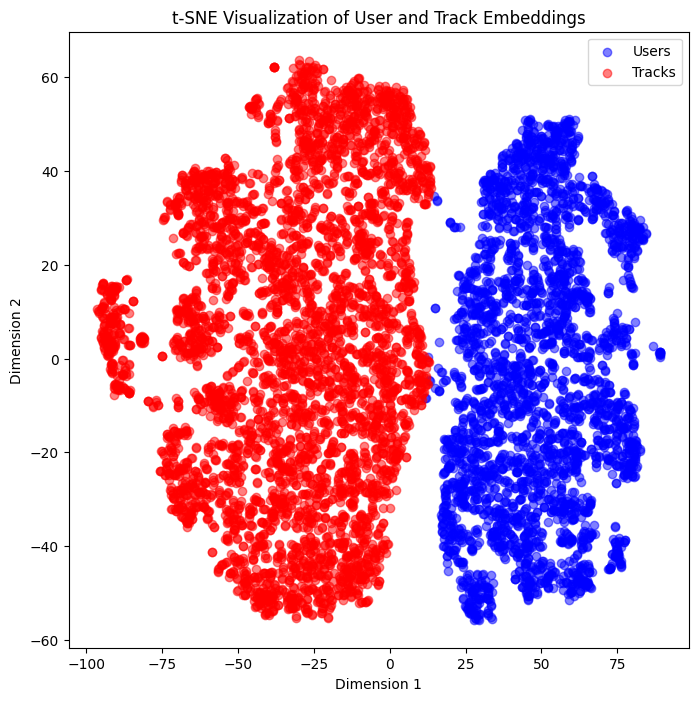

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Select a subset of users and tracks for visualization
num_users_subset = 3307
num_tracks_subset = 5000

selected_track_indices = np.random.choice(tracks_embs.shape[0], num_tracks_subset, replace=False)

tracks_embs_subset = tracks_embs[selected_track_indices]
users_embs_subset = users_embs[:num_users_subset]

#tracks_embs_subset = tracks_embs[:num_tracks_subset]

# Concatenate a subset of user and track embeddings
all_embeddings_subset = np.vstack((users_embs_subset, tracks_embs_subset))

# Perform t-SNE dimensionality reduction on the combined subset
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d_subset = tsne.fit_transform(all_embeddings_subset)

# Plot the 2D embeddings, coloring based on user or track nodes
plt.figure(figsize=(8, 8))

# Plot user embeddings
plt.scatter(embeddings_2d_subset[:num_users_subset, 0], embeddings_2d_subset[:num_users_subset, 1], c='b', alpha=0.5, label='Users')
# Plot track embeddings
plt.scatter(embeddings_2d_subset[num_users_subset:, 0], embeddings_2d_subset[num_users_subset:, 1], c='r', alpha=0.5, label='Tracks')

plt.title('t-SNE Visualization of User and Track Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

# Cosines Calculations from Embeddings

In [29]:
if not os.path.exists('data/embeddings/cosines/cos.npz'):
    len_users = np.linalg.norm(users_embs, axis=1)[:, np.newaxis]
    len_tracks = np.linalg.norm(tracks_embs, axis=1)[:, np.newaxis]

    cos = (users_embs @ tracks_embs.T) / (len_users @ len_tracks.T)
    np.savez_compressed('data/cos.npz', cosines=cos)
else:
    cos = np.load('data/embeddings/cosines/cos.npz')['cosines']
    print("Loaded cosines")
del users_embs
del tracks_embs

Loaded cosines


In [30]:
cos.shape[0]

3307

In [31]:
cos[0].shape

(252013,)

In [32]:
print(cos)
print(np.min(cos))
print(np.max(cos))
print(np.mean(cos))
print(np.std(cos))

[[ 0.4580886   0.67234874  0.59155935 ...  0.19334365 -0.06766067
   0.4846475 ]
 [ 0.38625047  0.34454256  0.09572447 ...  0.48556653  0.03431265
   0.58462214]
 [ 0.3363639   0.40249044  0.3092295  ... -0.31169364 -0.36627635
  -0.18311678]
 ...
 [ 0.07429178 -0.02705441  0.03067412 ... -0.55722666 -0.5680884
  -0.23578097]
 [-0.17760189 -0.31890962 -0.26793334 ... -0.2717834  -0.08054256
  -0.18490991]
 [ 0.20806023 -0.09315632 -0.03690587 ... -0.49505225 -0.5944006
  -0.61912435]]
-0.99707615
0.990118
-0.3332926
0.2668139


# Communities Test
basically the Communities that are made by louvain are compared with the cosine distances, and if these match (with the t-test) the communities 

In [35]:

# import 2 node graph
data = torch.load('data/pyg_data/train_hetero_data_2_nodes_co.pt')
colisten_graph = data

## NX Transformation
co_nx = to_networkx(colisten_graph)


In [36]:
len(co_nx.nodes), len(co_nx.edges)

(255320, 5415652)

In [38]:
from networkx.algorithms.community import louvain_communities
# Define the path to save or load the communities
communities_path = 'data/communities/louvain_communities.pkl'

# Check if the communities file exists
if os.path.exists(communities_path):
    # Load the communities if the file exists
    with open(communities_path, 'rb') as f:
        l_com = pickle.load(f)
    print("Communities loaded from file.")
else:
    # Run and save the communities if the file does not exist
    l_com = louvain_communities(co_nx, seed=42)
    with open(communities_path, 'wb') as f:
        pickle.dump(l_com, f)
    print("Communities generated and saved to file.")


Communities generated and saved to file.


In [39]:
# care that louvian is non-deterministic so you might geht different communities. Hence we are saving the first run of it and always loading it again. 
# slightly different embeddings will very likely tho not changet he final outcome by much. Especially since even if louvain changes a bit, it should still hold the same information generally. 
len(l_com)

9

In [40]:
# dictionary that shows all nodes and their assigment to their community (from 0 - 10)
node_community = {}
for c, group in enumerate(l_com):
    for u in group:
        node_community[u] = c

In [41]:
if 'cos' not in locals():
    cos = np.load('data/embeddings/cosines/cos.npz')['cosines']

## T-Test Difference Between Communities
According to the text, this is what I thought it did. Now I might think this is more of a "measurement" if the communities are actually seperated well.
So more or less a indicator if louvain worked well. Since the functions below takes all the distances / cosine similarities between each user and each song, and catigorizes them as "sim" or "diff".
Which is basically dividing all U-T cosine similarities into their respective communities. The t-test afterwards then  calculates if the difference between the values in each divided group
"sim" or "diff", are statistically different from the other group.

So all in all I think this code passage really just checks if the communities made by louvain are statistically different from each other. Or rather, if the nodes that are in the same community are actually similar. 

In [45]:
from collections import deque

# defines 3 types of similarity 
#1 
c_sim = 0
c_diff = 0
c_all_cos = 0

# iterates over each user (and then ALL songs)
for i in tqdm(range(len(colisten_graph['users']["node_id"]))):
    #iterates over ALL songs and looks if the song is in the SAME community as the User.
    for j in range(len(colisten_graph['songs']["node_id"])):
        c_all_cos += 1
        if node_community[i] == node_community[j]:
            c_sim += 1
        else:
            c_diff += 1

100%|██████████| 3307/3307 [01:29<00:00, 37.10it/s]


In [46]:
sim = np.empty((c_sim,))
diff = np.empty((c_diff,))
all_cos = np.empty((c_all_cos,))

In [47]:
sim = np.empty((c_sim,))
diff = np.empty((c_diff,))
all_cos = np.empty((c_all_cos,))
i_sim = 0
i_diff = 0
i_all_cos = 0

#for each user 3307
for i in tqdm(range(len(colisten_graph['users']["node_id"]))):
    #iterate over ALL songs
    for j in range(len(colisten_graph['songs']["node_id"])):
        #get the cos similarity of EACH User to EACH Song Node
        current_cos = cos[i, j]
        all_cos[i_all_cos] = current_cos # add this current cosine to the full list of cosines
        i_all_cos += 1
        
        # add the current user, track cos from this iteration to the same communities
        if node_community[i] == node_community[j]:
            sim[i_sim] = current_cos
            i_sim += 1
            
        #or different communities
        else:
            diff[i_diff] = current_cos
            i_diff += 1

# makes sure the number of the counters actually matches
print(c_diff == i_diff)
print(c_sim == i_sim)
print(c_all_cos == i_all_cos)

100%|██████████| 3307/3307 [05:37<00:00,  9.80it/s]

True
True
True


## Compute Test Statistics

In [56]:
import numpy as np
import pickle
import os

# Paths to save or load the data
sim_path = 'data/communities/t-test/sim.pickle'
diff_path = 'data/communities/t-test/diff.pickle'
all_cos_path = 'data/communities/t-test/all_cos.pickle'

# Check if the files exist and load them if they do
if not os.path.exists(sim_path):
    sim_loaded = None
    with open(sim_path, 'wb') as f:
        pickle.dump(sim_loaded, f)
else:
    with open(sim_path, 'rb') as f:
        sim_loaded = pickle.load(f)

if not os.path.exists(diff_path):
    diff_loaded = None
    with open(diff_path, 'wb') as f:
        pickle.dump(diff_loaded, f)
else:
    with open(diff_path, 'rb') as f:
        diff_loaded = pickle.load(f)

if not os.path.exists(all_cos_path):
    all_cos_loaded = None
    with open(all_cos_path, 'wb') as f:
        pickle.dump(all_cos_loaded, f)
else:
    with open(all_cos_path, 'rb') as f:
        all_cos_loaded = pickle.load(f)

# Print the loaded arrays to verify
print("Loaded sim array:", sim)
print("Loaded diff array:", diff)
print("Loaded all_cos array:", all_cos)


Loaded sim array: [ 0.45808861  0.58723533  0.62290901 ...  0.00839452 -0.36054707
 -0.51307678]
Loaded diff array: [ 0.67234874  0.59155935  0.697034   ... -0.49505225 -0.59440058
 -0.61912435]
Loaded all_cos array: [ 0.45808861  0.67234874  0.59155935 ... -0.49505225 -0.59440058
 -0.61912435]


In [57]:
print(len(all_cos))
print(np.mean(all_cos))
print(np.std(all_cos))
print(len(sim))
print(np.mean(sim))
print(np.std(sim))
print(len(diff))
print(np.mean(diff))
print(np.std(diff))

833406991
-0.33329227367660674
0.2668144338147683
170432068
-0.32396505178404983
0.2748733405463616
662974923
-0.335690038148072
0.2646499665460987


In [58]:
from scipy.stats import ttest_ind

ttest_ind(sim, diff, alternative='greater', equal_var=False)

TtestResult(statistic=500.42801696700104, pvalue=0.0, df=257579914.0820107)

In [59]:
ttest_ind(sim, all_cos, alternative='greater', equal_var=False)

TtestResult(statistic=405.63226471272645, pvalue=0.0, df=240612262.57701063)

In [60]:
ttest_ind(all_cos, diff, alternative='greater', equal_var=False)

TtestResult(statistic=173.46672213695854, pvalue=0.0, df=1426589432.012674)